In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error as mse

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
df = pd.read_csv('data/Metro_Interstate_Traffic_Volume.csv')
df['date_time'] = pd.to_datetime(df['date_time'])
df.drop_duplicates('date_time', inplace=True)
df.set_index('date_time', inplace=True)

print(df.shape)
df.head()

(40575, 8)


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2012-10-02 09:00:00,None,288.28,0.0,0.0,40,Clouds,scattered clouds,5545
2012-10-02 10:00:00,None,289.36,0.0,0.0,75,Clouds,broken clouds,4516
2012-10-02 11:00:00,None,289.58,0.0,0.0,90,Clouds,overcast clouds,4767
2012-10-02 12:00:00,None,290.13,0.0,0.0,90,Clouds,overcast clouds,5026
2012-10-02 13:00:00,None,291.14,0.0,0.0,75,Clouds,broken clouds,4918


In [7]:
pd.date_range(df.head(1).index[0], df.tail(1).index[0], freq='H')

DatetimeIndex(['2012-10-02 09:00:00', '2012-10-02 10:00:00',
               '2012-10-02 11:00:00', '2012-10-02 12:00:00',
               '2012-10-02 13:00:00', '2012-10-02 14:00:00',
               '2012-10-02 15:00:00', '2012-10-02 16:00:00',
               '2012-10-02 17:00:00', '2012-10-02 18:00:00',
               ...
               '2018-09-30 14:00:00', '2018-09-30 15:00:00',
               '2018-09-30 16:00:00', '2018-09-30 17:00:00',
               '2018-09-30 18:00:00', '2018-09-30 19:00:00',
               '2018-09-30 20:00:00', '2018-09-30 21:00:00',
               '2018-09-30 22:00:00', '2018-09-30 23:00:00'],
              dtype='datetime64[ns]', length=52551, freq='H')

In [4]:
### INSERT MISSING DATES ###

df = df.reindex(pd.date_range(df.head(1).index[0], df.tail(1).index[0], freq='H'))

df.shape

(52551, 8)

Text(0, 0.5, 'traffic_volume')

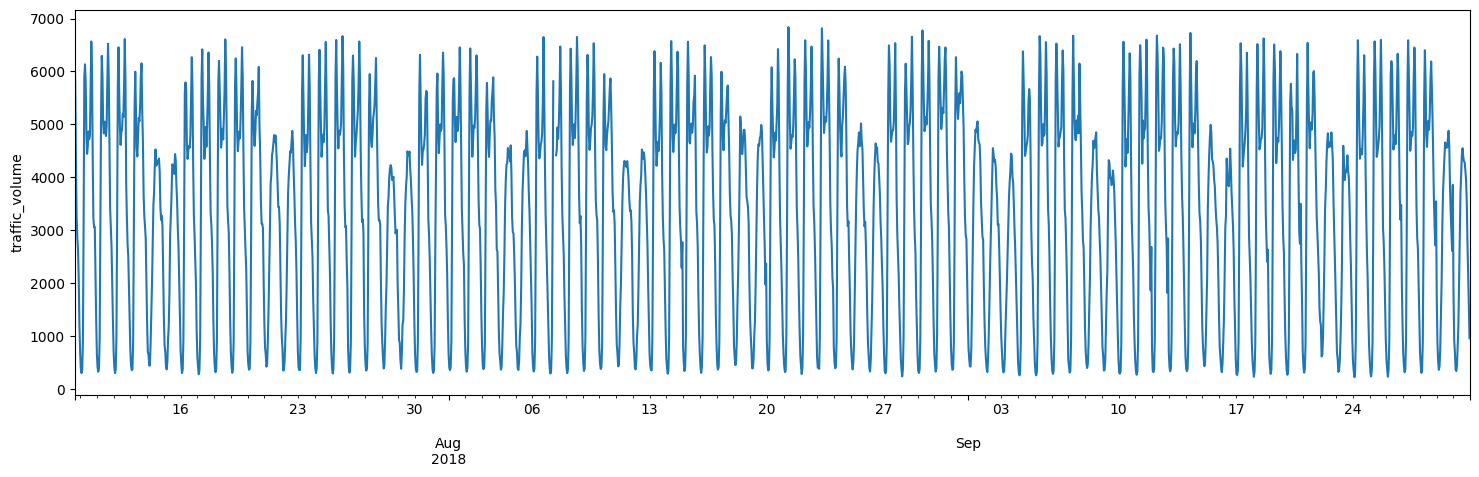

In [5]:
### PLOT TRAFFIC SAMPLE ###

df.traffic_volume.tail(2000).plot(figsize=(18,5))
plt.ylabel('traffic_volume')

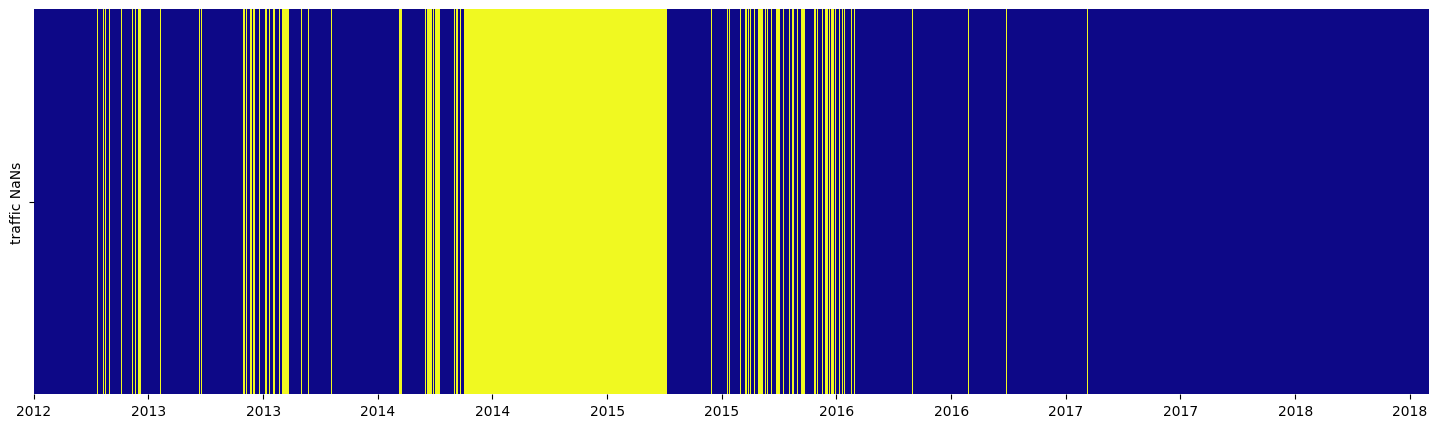

In [6]:
### PLOT MISSING VALUES OVER TIME ###

plt.figure(figsize=(18,5))
sns.heatmap(df[['traffic_volume']].isna().T, cbar=False, cmap='plasma', 
            xticklabels=False, yticklabels=['traffic NaNs'])
plt.xticks(range(0,len(df), 24*180), list(df.index.year[::24*180]))
np.set_printoptions(False)

In [8]:
### FILL MISSING VALUES ###

df = df[df.index.year.isin([2016,2017,2018])].copy()

df = pd.concat([df.select_dtypes(include=['object']).fillna(method='backfill'),
                df.select_dtypes(include=['float']).interpolate()], axis=1)

df.shape

(24096, 8)

Text(0.5, 0, 'month')

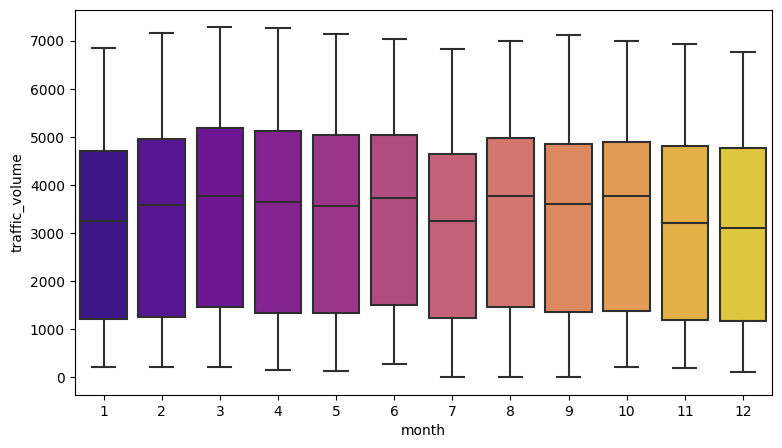

In [9]:
### PLOT TRAFFIC DISTRIBUTION IN EACH MONTH ###

plt.figure(figsize=(9,5))
sns.boxplot(x=df.index.month, y=df.traffic_volume, palette='plasma')

plt.ylabel('traffic_volume'); plt.xlabel('month')

Text(0.5, 0, 'weekday')

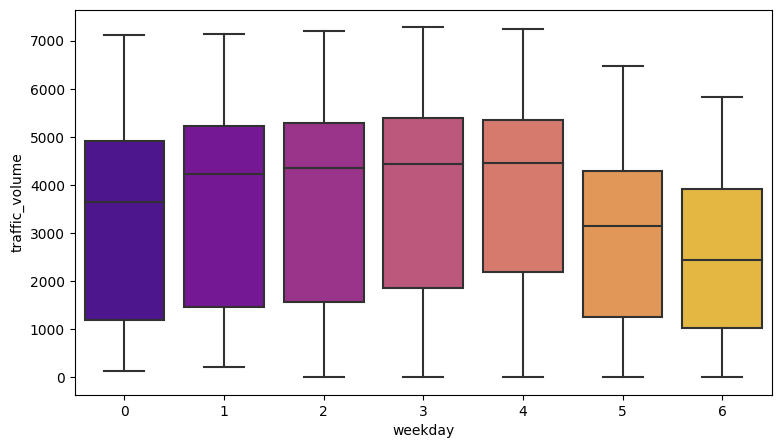

In [10]:
### PLOT TRAFFIC DISTRIBUTION IN EACH WEEKDAY ###

plt.figure(figsize=(9,5))
sns.boxplot(x=df.index.weekday, y=df.traffic_volume, palette='plasma')

plt.ylabel('traffic_volume'); plt.xlabel('weekday')

Text(0.5, 0, 'hour')

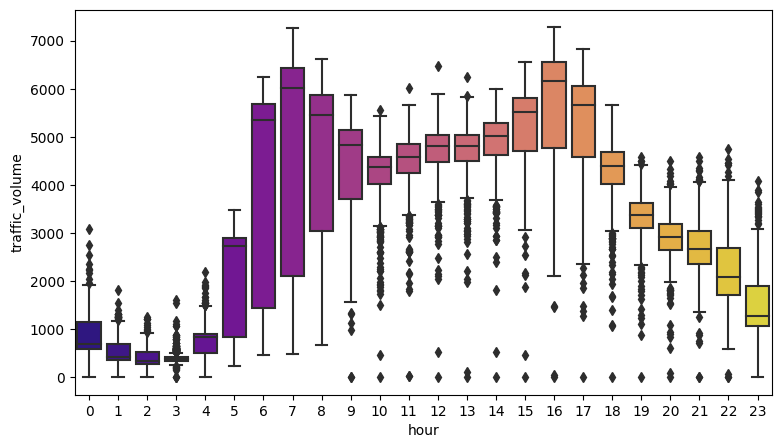

In [11]:
### PLOT TRAFFIC DISTRIBUTION IN EACH HOUR ###

plt.figure(figsize=(9,5))
sns.boxplot(x=df.index.hour, y=df.traffic_volume, palette='plasma')

plt.ylabel('traffic_volume'); plt.xlabel('hour')

In [12]:
### NUMERICAL ENCODE CATEGORICAL COLUMNS ###

map_col = dict()

X = df.select_dtypes(include=['object']).copy()
for i,cat in enumerate(X):
    X[cat] = df[cat].factorize()[0]
    map_col[cat] = i

X['month'] = df.index.month;  i += 1;  map_col['month'] = i
X['weekday'] = df.index.weekday;  i += 1;  map_col['weekday'] = i
X['hour'] = df.index.hour;  i += 1;  map_col['hour'] = i
X.shape

(24096, 6)

In [13]:
### UTILITY FUNCTION FOR 3D SEQUENCE GENERATION ###

def gen_seq(id_df, seq_length, seq_cols):

    data_matrix =  id_df[seq_cols]
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length, 1), range(seq_length, num_elements, 1)):
        
        yield data_matrix[stop-sequence_length:stop].values.reshape((-1,len(seq_cols)))

In [14]:
### GENERATE 3D SEQUENCES ###

sequence_length = 24*7

sequence_input = []
sequence_target = []

for seq in gen_seq(X, sequence_length, X.columns):
    sequence_input.append(seq)
    
for seq in gen_seq(df, sequence_length, ['traffic_volume']):
    sequence_target.append(seq)
    
sequence_input = np.asarray(sequence_input)
sequence_target = np.asarray(sequence_target)

sequence_input.shape, sequence_target.shape

((23928, 168, 6), (23928, 168, 1))

In [15]:
### UTILITY FUNCTION TO INSERT RANDOM MISSING INTERVALS ###

def drop_fill_pieces(sequence_input, sequence_target, missing_len, missing_val=np.nan, size=0.2):
    
    sequence_input = np.copy(sequence_input)
    sequence_target = np.copy(sequence_target)
    
    _id_seq = np.random.choice(range(len(sequence_target)), int(len(sequence_target)*size), replace=False)
    _id_time = np.random.randint(0,sequence_length-missing_len, int(len(sequence_target)*size))
    
    for i,t in zip(_id_seq, _id_time):
        sequence_input[i, t:t+missing_len, 
                       [map_col['holiday'], 
                        map_col['weather_main'],
                        map_col['weather_description']]] = -1
        sequence_target[i, t:t+missing_len, :] = missing_val
        
    sequence_input[:,:, 
                   [map_col['holiday'], 
                    map_col['weather_main'],
                    map_col['weather_description']]] += 1
    
    return sequence_input, sequence_target

In [16]:
### INSERT MISSING INTERVALS AT RANDOM ###

np.random.seed(33)

missing_len = 24
sequence_input, sequence_target_drop = drop_fill_pieces(sequence_input, sequence_target,
                                                        missing_len=missing_len, size=0.6)

sequence_input.shape, sequence_target_drop.shape

((23928, 168, 6), (23928, 168, 1))

In [17]:
### TRAIN TEST SPLIT ###

train_size = 0.8

sequence_input_train = sequence_input[:int(len(sequence_input)*train_size)]
sequence_input_test = sequence_input[int(len(sequence_input)*train_size):]
print(sequence_input_train.shape, sequence_input_test.shape)

sequence_target_train = sequence_target[:int(len(sequence_target)*train_size)]
sequence_target_test = sequence_target[int(len(sequence_target)*train_size):]
print(sequence_target_train.shape, sequence_target_test.shape)

sequence_target_drop_train = sequence_target_drop[:int(len(sequence_target_drop)*train_size)]
sequence_target_drop_test = sequence_target_drop[int(len(sequence_target_drop)*train_size):]
print(sequence_target_drop_train.shape, sequence_target_drop_test.shape)

(19142, 168, 6) (4786, 168, 6)
(19142, 168, 1) (4786, 168, 1)
(19142, 168, 1) (4786, 168, 1)
